In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm

In [ ]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

### Load grids and data

In [6]:
import datetime

In [7]:
ds = xr.open_mfdataset("/work/hfd/wmt_global_tmp/*.nc")
ds['tos'] = ds.thetao.isel(zl=0)
ds['sos'] = ds.so.isel(zl=0)

snap = xr.Dataset()
for v in ["thetao", "so", "thkcello"]:
    snap[v] = ds[v].rename({"time":"time_bounds"}).assign_coords({"time_bounds":ds.time.values - datetime.timedelta(hours=1)})

ds = ds.isel(time=slice(0,1))
snap = snap.isel(time_bounds=slice(0,2))

In [8]:
def add_estimated_layer_interfaces(ds):
        return ds.assign_coords({"zi": xr.DataArray(
            np.concatenate([[0], 0.5*(ds.zl.values[1:]+ds.zl.values[0:-1]), [6000]]),
            dims=('zi',)
        )})

ds = add_estimated_layer_interfaces(ds)
snap = add_estimated_layer_interfaces(snap)

In [9]:
ocean_grid = xr.open_dataset("/archive/jet/FMS2021.02_mom6_devgfdl_20221223/OM4p5_JRA55do1.5_0netfw_cycle1/gfdl.ncrc4-intel18-prod/history/19580101.ocean_static.nc")

In [10]:
# Add core coordinates of ocean_grid to ds
ds = ds.assign_coords({
    "wet": xr.DataArray(ocean_grid["wet"].values, dims=('yh', 'xh',)),
    "areacello": xr.DataArray(ocean_grid["areacello"].values, dims=('yh', 'xh',)),
    'xq': xr.DataArray(ocean_grid['xq'].values, dims=('xq',)),
    'yq': xr.DataArray(ocean_grid['yq'].values, dims=('yq',)),
    'geolon': xr.DataArray(ocean_grid['geolon'].values, dims=('yh','xh')),
    'geolat': xr.DataArray(ocean_grid['geolat'].values, dims=('yh','xh')),
    'geolon_u': xr.DataArray(ocean_grid['geolon_u'].values, dims=('yh','xq')),
    'geolat_u': xr.DataArray(ocean_grid['geolat_u'].values, dims=('yh','xq')),
    'geolon_v': xr.DataArray(ocean_grid['geolon_v'].values, dims=('yq','xh')),
    'geolat_v': xr.DataArray(ocean_grid['geolat_v'].values, dims=('yq','xh')),
    'geolon_c': xr.DataArray(ocean_grid['geolon_c'].values, dims=('yq','xq')),
    'geolat_c': xr.DataArray(ocean_grid['geolat_c'].values, dims=('yq','xq')),
    'dxt': xr.DataArray(ocean_grid['dxt'].values, dims=('yh', 'xh',)),
    'dyt': xr.DataArray(ocean_grid['dyt'].values, dims=('yh', 'xh',)),
    'dxCv': xr.DataArray(ocean_grid['dxCv'].values, dims=('yq', 'xh',)),
    'dyCu': xr.DataArray(ocean_grid['dyCu'].values, dims=('yh', 'xq',)),
    'dxCu': xr.DataArray(ocean_grid['dxCu'].values, dims=('yh', 'xq',)),
    'dyCv': xr.DataArray(ocean_grid['dyCv'].values, dims=('yq', 'xh',)),
    'deptho': xr.DataArray(ocean_grid['deptho'].values, dims=('yh', 'xh')),
})
# lon, lat variables required by gsw package for sea water equation thermodynamics
ds['lon'] = ds.geolon
ds['lat'] = ds.geolat

snap['lon'] = ds.geolon
snap['lat'] = ds.geolat

ds = ds.isel(xh=slice(1,None), yh=slice(1,None))
snap = snap.isel(xh=slice(1,None), yh=slice(1,None))

In [11]:
# Get density variables
coords = {'Z': {'center': 'zl', 'outer': 'zi'}}
wm_ds = xwmt.WaterMass(xgcm.Grid(ds, coords=coords, metrics={}, boundary={"Z":"extend"}, autoparse_metadata=False))
wm_snap = xwmt.WaterMass(xgcm.Grid(snap, coords=coords, metrics={}, boundary={"Z":"extend"}, autoparse_metadata=False))

ds['sigma0'] = wm_ds.get_density("sigma0")
snap['sigma0'] = wm_snap.get_density("sigma0")

snap = snap.rename({v:f"{v}_bounds" for v in snap.data_vars if "zl" in snap[v].dims})

In [12]:
ds = xr.merge([ds, snap])

# z-coordinate dataset containing basic state variables
coords = {
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
    'Z': {'center': 'zl', 'outer': 'zi'},
}
metrics = {
    ('X','Y'): "areacello",
}
boundary = {"X":"extend", "Y":"extend", "Z":"extend"}
grid = xgcm.Grid(ds, coords=coords, metrics=metrics, boundary=boundary, autoparse_metadata=False)

In [25]:
grid._ds

<xarray.Dataset> Size: 14GB
Dimensions:                                                                                                 (
                                                                                                             xh: 719,
                                                                                                             yh: 575,
                                                                                                             zl: 75,
                                                                                                             time: 1,
                                                                                                             nv: 2,
                                                                                                             xq: 720,
                                                                                                             yq: 576,
                                                                                                             zi: 76,
                                                                                                             time_bounds: 2)
Coordinates: (12/26)
  * xh                                                                                                      (xh) float64 6kB ...
  * yh                                                                                                      (yh) float64 5kB ...
  * zl                                                                                                      (zl) float64 600B ...
  * time                                                                                                    (time) object 8B ...
  * nv                                                                                                      (nv) float64 16B ...
  * zi                                                                                                      (zi) float64 608B ...
    ...                                                                                                      ...
    dxCv                                                                                                    (yq, xh) float32 2MB ...
    dyCu                                                                                                    (yh, xq) float32 2MB ...
    dxCu                                                                                                    (yh, xq) float32 2MB ...
    dyCv                                                                                                    (yq, xh) float32 2MB ...
    deptho                                                                                                  (yh, xh) float32 2MB ...
  * time_bounds                                                                                             (time_bounds) object 16B ...
Data variables: (12/136)
    thetao                                                                                                  (time, zl, yh, xh) float32 124MB dask.array<chunksize=(1, 75, 575, 719), meta=np.ndarray>
    so                                                                                                      (time, zl, yh, xh) float32 124MB dask.array<chunksize=(1, 75, 575, 719), meta=np.ndarray>
    rhopot2                                                                                                 (time, zl, yh, xh) float32 124MB dask.array<chunksize=(1, 75, 575, 719), meta=np.ndarray>
    thkcello                                                                                                (time, zl, yh, xh) float32 124MB dask.array<chunksize=(1, 75, 575, 719), meta=np.ndarray>
    volcello                                                                                                (time, zl, yh, xh) float32 124MB dask.array<chunksize=(1, 75, 575, 719), meta=np.ndarray>
    opottemptend                                                      

# Part 1. Water mass budgets within a fixed sub-region

### Collecting high-level budget terms

In [14]:
import xbudget
budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly")
xbudget.collect_budgets(grid, budgets_dict)

/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


### Specifying the horizontal boundaries of our water mass

/vftmp/Henri.Drake/pid10200/ipykernel_10763/3267727649.py:14: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(pc, label="depth [m]")


(-50.0, 0.0)

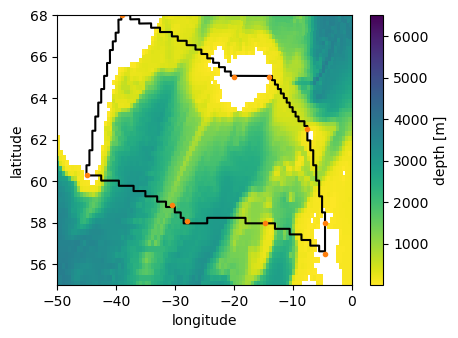

In [29]:
# Note: the properties of this region are quite different from the rest of the Baltic!
name = "intBaltic"
lons = np.array([-39.,  -20.,  -14, -7.5, -4.5,  -4.5, -14.7, -28.00, -30.54, -44.90])
lats = np.array([ 68,     65,   65, 62.5,   58,  56.5,  58.0,  58.05,  58.86,  60.30])
region = regionate.GriddedRegion(name, lons, lats, grid)

plt.figure(figsize=(4.75,3.5))
pc = plt.pcolor(
    grid._ds['geolon_c'],
    grid._ds['geolat_c'],
    grid._ds['deptho'],
    cmap="viridis_r"
)
plt.colorbar(pc, label="depth [m]")
plt.plot(regionate.loop(region.lons), regionate.loop(region.lats), color="k");
plt.plot(lons, lats, "C1.");
plt.xlabel("longitude");
plt.ylabel("latitude");

plt.ylim(55, 68)
plt.xlim(-50, 0)

### Computing water mass budgets

In [16]:
import warnings

lam = "sigma0"
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb = xwmb.WaterMassBudget(
        grid,
        budgets_dict,
        region
    )
    wmb.mass_budget(lam, default_bins=True, integrate=True, along_section=True)
    wmb.wmt.load()
    wmt = wmb.wmt

In [17]:
transport = wmb.grid._ds["convergent_mass_transport_less_than"].compute()

In [18]:
transport_north = -transport.isel(sect=slice(0, 115))
transport_south = transport.isel(sect=slice(115, None))

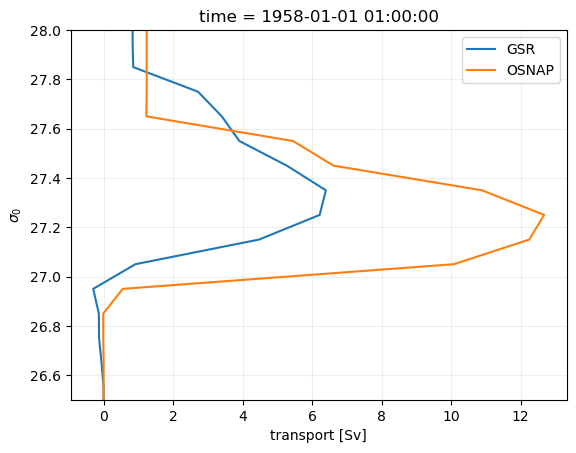

In [19]:
(transport_north.sum("sect")/1035*1e-6).plot(y="sigma0_i_target", label="GSR")
(transport_south.sum("sect")/1035*1e-6).plot(y="sigma0_i_target", label="OSNAP")
plt.ylim(26.5, 28)
plt.xlabel("transport [Sv]")
plt.ylabel(r"$\sigma_{0}$")
plt.grid(True, alpha=0.2)
plt.legend()

In [20]:
toSv = 1/1035*1e-6

In [21]:
import matplotlib.pyplot as plt

def hovmoller(wmt, var, robust=False, units="kg", **kwargs):
    da = wmt[var]
    if robust:
        vmax = np.abs(da).quantile(0.95).compute()
        kwargs["vmin"] = -vmax
        kwargs["vmax"] = vmax

    coord_bounds = wmt[[c for c in wmt.coords if "i_target" in c][0]]
    time_idx_bounds = xr.DataArray(np.arange(0, wmt.time_bounds.size), dims=('time_bounds',))
    pc = plt.pcolor(
        time_idx_bounds,
        coord_bounds,
        da.transpose() if da.dims[0] == "time" else da,
        **kwargs
    )

    dtick = da.time.size//12
    date_str = [f"{d.year}-{str(d.month).zfill(2)}-{str(d.day).zfill(2)}" for d in wmt["time_bounds"].values[::dtick]]
    plt.xticks(time_idx_bounds[::dtick], date_str, rotation=90)
    plt.colorbar(label=f"transformation rate [{units}]")
    for coord_bound in coord_bounds:
        plt.axhline(coord_bound, color="k", lw=0.25)
    
    return pc

def stairs(wmt, var, units="kg", **kwargs):
    da = wmt[var]
    coord = wmt[[c for c in wmt.coords if "l_target" in c][0]]
    coord_bounds = wmt[[c for c in wmt.coords if "i_target" in c][0]]
    l = plt.stairs(da, coord_bounds, **kwargs, orientation="horizontal")
    plt.xlabel(f"mean transformation rate [{units}]")
    return l

ValueError: Size mismatch between "values" and "edges". Expected `len(values) + 1 == len(edges)`, but `len(values) = 206712500` and `len(edges) = 501`.

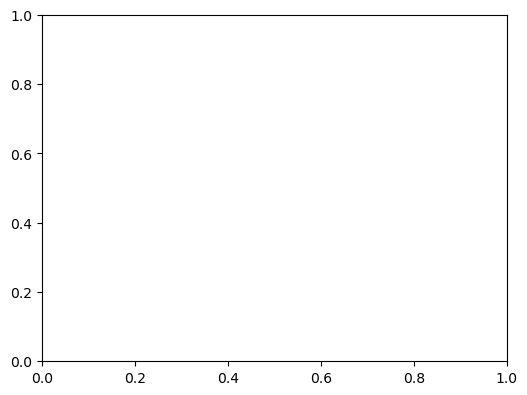

In [24]:
plt.figure(figsize=(6,4.5))

kwargs = {"units":"Sv", "alpha":0.7, "lw":1.5}

wmt_mean = wmt.mean('time')*toSv
stairs( wmt_mean, 'mass_tendency',             label=r"$\partial_{t} \mathcal{M}$",**kwargs)
stairs(-wmt_mean, 'mass_source',               label=r"$-\mathcal{S}$",            **kwargs)
stairs(-wmt_mean, 'convergent_mass_transport', label=r"$-\Psi$",                   **kwargs)
stairs( wmt_mean, 'boundary_fluxes',           label=r"$\mathcal{G}^{(BF)}$",      **kwargs)
stairs( wmt_mean, 'diffusion',                 label=r"$\mathcal{G}^{(Mix)}$",     **kwargs)
stairs( wmt_mean, 'spurious_numerical_mixing', label=r"$\mathcal{N}$", **kwargs)

plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{0}$ [kg/m$^{3}$]");
plt.ylim(28.0, 26.8);

In [23]:
import warnings

lam = "sigma0"
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb_map = xwmb.WaterMassBudget(
        grid,
        budgets_dict,
        region
    )
    wmb_map.mass_budget(lam, default_bins=True, integrate=False)
    wmb_map.wmt.load()
    wmt = wmb_map.wmt